# Excess Power
The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations

Equations for Level Acceleration Data Reduction

1. **Dynamic Pressure (qc):**
   $$
   q_c = P_{\text{ssl}} \left\{ \left[ 1 + 0.2 \left( \frac{V_c}{a_{\text{ssl}}} \right)^2 \right]^{3.5} - 1 \right\}
   $$

2. **Ambient Pressure (Pa):**
   $$
   P_a = P_{\text{ssl}} \left( 1 - 6.8755856 \times 10^{-6} H_p \right)^{5.255863}
   $$

3. **Mach Number (M):**
   $$
   M = \sqrt{\frac{2}{\gamma - 1} \left[ \left( \frac{q_c}{P_a} + 1 \right)^{\frac{\gamma - 1}{\gamma}} - 1 \right]}
   $$

4. **Ambient Temperature (Ta):**
   $$
   T_a = \frac{\text{OAT} + 273.15}{1 + \frac{\gamma - 1}{2} K_T M^2}
   $$

5. **Altitude Correction (h):**
   $$
   h = H_p \frac{T_{a_{\text{Test}}}}{T_{a_{\text{Std}}}}
   $$

6. **True Airspeed (VT):**
   $$
   V_T = M \sqrt{\gamma g_c R T_a}
   $$

1. **Energy Height**
$$
E_h = h+\frac{V^2_T}{2g}
$$

### Variables

- $a_{\text{ssl}}$: Standard sea level speed of sound - 661.483 kn
- $E_h$: Energy height - ft
- $g$: Gravitational acceleration - ft/s²
- $\gamma$: Ratio of specific heats
- $g_c$: Conversion constant - 32.17 $lb_m$/slug
- $h$: Tapeline altitude - ft
- $H_p$: Calibrated pressure altitude - ft
- $K_T$: Temperature recovery factor
- $M$: Mach number
- OAT: Outside air temperature - °C
- $P_a$: Ambient pressure - psf
- $P_{\text{ssl}}$: Standard sea level pressure - 2116.217 psf
- $q_c$: Impact pressure - psf
- $R$: Engineering gas constant for air - 96.93 ft-lbf/$lb_m$-°K
- $T_a$: Ambient temperature - °K
- $T_{\text{aStd}}$: Standard ambient temperature - °K
- $T_{\text{aTest}}$: Test ambient temperature - °K
- $V_c$: Calibrated airspeed - kn
- $V_T$: True airspeed - ft/s

## Pilot's Data
The following data is required at intervals throughout the acceleration run:
- Time (s)
- $H_{P_o}$ Pressure Altitude, observed (ft)
- $V_o$ Indicated Airspeed, observed (knots)
- OAT Outside air temperature
- $W_f$ Remaining fuel weight (lbs)


## Order of Analysis

Correct observed altitude and airspeed data to calibrated altitude and airspeed.  Using calibrated altitude, airspeed, and OAT compute Eh as follows:

| Step | Parameter           | Notation | Formula    | Units | Remarks                    |
|------|----------------------|----------|------------|-------|----------------------------|
| 1    | Impact pressure      | $q_c$    | Eq 5.25    | psf   |                            |
| 2    | Ambient pressure     | $P_a$    | Eq 5.26    | psf   |                            |
| 3    | Mach number          | $M$      | Eq 5.27    |       |                            |
| 4    | Ambient temperature  | $T_a$    | Eq 5.28    | °K    | Or from reference source   |
| 5    | Tapeline height      | $h$      | Eq 5.29    | ft    |                            |
| 6    | True airspeed        | $V_T$    | Eq 5.30    | ft/s  |                            |
| 7    | Energy height        | $E_h$    | Eq 5.7     | ft    |                            |

## Output
1. Energy Height vs. Elapsed Time Plot
2. Test Specific Excess Power vs. Mach

## Corrections for non-standard conditions
Corrections for:

1. $W$ for non-standard weight.
1. $V_T$ for non-standard temperature.
1. $T$ for temperature effect on thrust.
1. $D$ for induced drag change resulting from the weight correction.



1. W for non-standard weight
$$
\frac{W_{\text{Test}}}{W_{\text{s}}}
$$

2. T for temperature effect on thrust (computed from engine thrust model)
$$
\Delta T = f(T_a)
$$

3. D for induced drag change resulting from the weight correction
$$
\Delta D = D_{\text{Std}}-D_{\text{Test}} = \frac{2(W_{\text{Std}}^2-W_{\text{Test}}^2)}{\pi e \text{AR}S\gamma P_a M^2}
$$

Which can then be used for:

4. $P_{s_\text{std}}$
$$
P_{s_\text{Std}} = P_{\text{sTest}} \frac{W_{\text{Test}}}{W_{\text{Std}}} \sqrt{\frac{T_{a_{\text{Std}}}}{T_{a_{\text{Test}}}}} + \frac{V_{T_{\text{Std}}}}{W_{\text{Std}}} \left( \Delta T_{N_x} - \Delta D \right)
$$

## Python Code

In [23]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

### Constants

In [24]:
P_ssl = 2116.217  # psf
a_ssl = atm.kts_to_fps(661.483)  # knots
gamma = 1.4
g = 32.17  # ft/s^2
R = 96.93
T_ssl = 288.15  # K

### Functions

1. **Dynamic Pressure (qc):**
   $$
   q_c = P_{\text{ssl}} \left\{ \left[ 1 + 0.2 \left( \frac{V_c}{a_{\text{ssl}}} \right)^2 \right]^{3.5} - 1 \right\}
   $$

In [25]:
def q_c(v_c):
    return P_ssl * ((1 + 0.2 * (v_c / a_ssl) ** 2) ** 3.5 - 1)

2. **Ambient Pressure (Pa):**
   $$
   P_a = P_{\text{ssl}} \left( 1 - 6.8755856 \times 10^{-6} H_p \right)^{5.255863}
   $$

In [26]:
def P_a(h_p):
    # return P_ssl * (1 - 6.8755856e-6 * h_p) ** 5.255863
    return atm.calc_Pa(h_p)

3. **Mach Number (M):**
   $$
   M = \sqrt{\frac{2}{\gamma - 1} \left[ \left( \frac{q_c}{P_a} + 1 \right)^{\frac{\gamma - 1}{\gamma}} - 1 \right]}
   $$

In [27]:
def mach(q_c, P_a):
    return np.sqrt(2 / (gamma - 1) * (((q_c / P_a) + 1) ** ((gamma - 1) / gamma) - 1))

4. **Ambient Temperature (Ta):**
   $$
   T_a = \frac{\text{OAT} + 273.15}{1 + \frac{\gamma - 1}{2} K_T M^2}
   $$

In [28]:
def T_a(oat, K, M):
    return (oat + 273.15) * (1 + (gamma - 1) / 2 * K * M**2)

5. **Altitude Correction (h):**
   $$
   h = H_p \frac{T_{a_{\text{Test}}}}{T_{a_{\text{Std}}}}
   $$

In [29]:
def h(h_p, T_a_test, T_a_std):
    return h_p * (T_a_test / T_a_std)

6. **True Airspeed (VT):**
   $$
   V_T = M \sqrt{\gamma g_c R T_a}
   $$

In [30]:
def v_t(M, T_a):
    return M * np.sqrt(gamma * g * R * T_a)

7. **Energy Height**
$$
E_h = h+\frac{V^2_T}{2g}
$$

In [31]:
def e_h(h, v_t):
    return h + (v_t**2) / (2 * g)

### Helper Functions

In [32]:
def standardize_columns(df, column_mapping):
    # Rename columns based on the exact mapping
    df.rename(columns=column_mapping, inplace=True)
    return df

### Load Data

In [33]:
# df_accel = pd.read_excel("./demo_data//level_accel_data.xlsx", header=1)
# df_accel = pd.read_excel("./demo_data/level_accel_10k_clean.xlsx")
df_accel = pd.read_excel("./data/level_accel_data.xlsx", sheet_name="Sortie 1 - 10k", header=1)
# Exact column names from the spreadsheet as keys, and standardized names as values
# column_mapping = {
#     # "Column Name in Excel": "Standardized Name"
#     "Time": "time",
#     "ASL": "Hp_i",
#     "IAS": "V_i",
#     # "TT [℃]": "oat",
#     "fuel": "w_f",
# }
column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Time [s]": "time",
    "Hi [ft]": "Hp_i",
    "Vi [kts]": "V_i",
    "OAT [℃]": "oat",
    "Wf [lbs]": "w_f",
}
# df_accel["oat"] = df_accel.apply(
#     lambda row: (atm.get_std_theta(row["ASL"]) * atm.T_0) - 273.15, axis=1
# )

# For level_accel_data.xlsx
# column_mapping = {
#     # "Column Name in Excel": "Standardized Name"
#     "Time [s]": "time",
#     "Hi [ft]": "Hp_i",
#     "Vi [kts]": "V_i",
#     "TT [℃]": "oat",
#     "Wf [lbs]": "w_f",
# }

# Apply standardization
dfs = [standardize_columns(df, column_mapping) for df in [df_accel]]

### Test Parameters

In [34]:
w_s = 11900  # lb
ZFW = 9000  # lb

### Data Analysis

In [35]:
df_accel["v_i_fps"] = df_accel["V_i"] * 1.68781
df_accel["q_c"] = q_c(df_accel["v_i_fps"])
df_accel["P_a"] = df_accel.apply(lambda row: P_a(row["Hp_i"]), axis=1)
df_accel["M"] = mach(df_accel["q_c"], df_accel["P_a"])
# df_accel["T_a"] = T_a(df_accel["oat"], 0.2, df_accel["M"])
# TODO: Work out what to do about unknown K (recovery factor) value
df_accel["T_a"] = df_accel["oat"] + atm.celsius_kelvin
df_accel["T_a_std"] = df_accel.apply(
    lambda row: atm.get_std_theta(row["Hp_i"]) * atm.T_0, axis=1
)
df_accel["h"] = df_accel.apply(
    lambda row: h(row["Hp_i"], row["T_a"], row["T_a_std"]), axis=1
)
df_accel["v_t_fps"] = v_t(df_accel["M"], df_accel["T_a"])
df_accel["e_h"] = e_h(df_accel["h"], df_accel["v_t_fps"])

df_accel["p_s_test"] = np.gradient(df_accel["e_h"], df_accel["time"])
# df_accel["p_s_test"] = savgol_filter(
#     np.gradient(df_accel["e_h"], df_accel["time"]), len(df_accel) // 5, 2
# )

1. Correct $V_T$ for non standard temperature
$$
V_{T_{\text{Std}}} = V_{T_{\text{test}}} \sqrt{\frac{T_{a_{\text{Std}}}}{T_{a_{\text{Test}}}}}

In [36]:
def v_t_std(v_t_t, T_a_t, T_a_std):
    return v_t_t * np.sqrt(T_a_std / T_a_t)

In [37]:
def ps_std(p_s_t, w_test, w_s, T_a_std, T_a_t, V_t_std, delta_thrust_nx, delta_drag):
    return p_s_t * w_test / w_s * np.sqrt(T_a_std / T_a_t) + V_t_std / w_s * (
        delta_thrust_nx - delta_drag
    )

### Climb Correction Factor

$$
\text{CCF} = 1 + \left( \frac{V_{T_{\text{std}}}}{g} \frac{dV}{dh} \right)
$$

In [38]:
def VbyH(airspeed, height):
    """
    Calculate dV/dH from airspeed in meters per second and height in meters.

    In support of climb correction factor
    """
    dH_raw = np.gradient(height)
    dH = np.where(dH_raw != 0.0, dH_raw, np.nan)  # avoid divide by zero
    return np.gradient(airspeed) / dH


def ccf(true_airspeed_std, height):
    """
    Calculate Climb Correction Factor.

    (Eq 5.50)
    """
    return 1 + ((true_airspeed_std / g) * VbyH(true_airspeed_std, height))

In [39]:
df_accel["v_t_standard"] = df_accel.apply(
    lambda row: v_t_std(row["v_t_fps"], row["T_a"], row["T_a_std"]), axis=1
)
df_accel["W"] = ZFW + df_accel["w_f"]

# NOTE: Assuming delta_thrust_nx and delta_drag are calculated or set to 1 for simplicity
delta_thrust_nx = 1
delta_drag = 1

df_accel["p_s_std"] = df_accel.apply(
    lambda row: ps_std(
        row["p_s_test"],
        row["W"],
        w_s,
        row["T_a_std"],
        row["T_a"],
        row["v_t_standard"],
        delta_thrust_nx,
        delta_drag,
    ),
    axis=1,
)

# TODO: need to add a VbyH function as per Daedalus
# df_accel["VbyH"] = VbyH(df_accel["v_t_standard"], df_accel["h"])
df_accel["ccf"] = ccf(df_accel["v_t_standard"], df_accel["h"])
df_accel["dh/dt_std"] = df_accel["p_s_std"] / df_accel["ccf"]
df_accel["ROC"] = np.gradient(df_accel["h"], df_accel["time"])

# Need dh/dt_test to calculate climb_angle_test
df_accel["climb_angle_test"] = np.arcsin(df_accel["ROC"] / df_accel["v_t_fps"])
df_accel["climb_angle_std"] = np.arcsin(
    df_accel["dh/dt_std"] / df_accel["v_t_standard"]
)

df_accel.to_excel("./output/accel_output.xlsx")

In [40]:
df_accel

,time,V_i,Hp_i,oat,w_f,ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,e_h,p_s_test,v_t_standard,W,p_s_std,ccf,dh/dt_std,ROC,climb_angle_test,climb_angle_std
0,0,148,10010,-8,2800,8620,0,0,0,0,...,11194.616363,66.882031,291.246195,11800,66.715036,-8.001202,-8.338126,-7.424782,-0.025648,-0.028633
1,10,186,9940,-8,2800,8620,0,0,0,0,...,11863.436669,68.122576,365.066363,11800,67.970043,-16.658226,-4.080269,-4.242419,-0.011693,-0.011177
2,20,216,9930,-8,2800,8620,0,0,0,0,...,12557.067878,76.147681,423.275368,11800,75.979982,145.409222,0.522525,0.530107,0.001260,0.001234
3,30,246,9950,-8,2800,8620,0,0,0,0,...,13386.390282,80.746223,481.429733,11800,80.562452,NaN,NaN,0.000000,0.000000,NaN
4,40,273,9930,-8,2800,8620,0,0,0,0,...,14171.992340,60.790966,533.263442,11800,60.657087,-119.165362,-0.509016,-0.530107,-0.001000,-0.000955
5,50,286,9940,-8,2800,8620,0,0,0,0,...,14602.209605,50.207095,558.286453,11800,50.094677,95.229428,0.526042,0.530028,0.000955,0.000942
6,60,303,9940,-8,2800,8620,0,0,0,0,...,15176.134249,60.748389,590.821976,11800,60.612367,NaN,NaN,0.000000,0.000000,NaN
7,70,321,9940,-8,2800,8620,0,0,0,0,...,15817.177382,67.097863,625.163748,11800,66.947624,64.008493,1.045918,1.060292,0.001707,0.001673
8,80,339,9960,-8,2800,8620,0,0,0,0,...,16518.091509,50.597350,659.578152,11800,50.480332,-98.037230,-0.514910,-0.530028,-0.000809,-0.000781
9,90,348,9930,-8,2800,8620,0,0,0,0,...,16829.124385,28.764955,676.368761,11800,28.701606,-55.204131,-0.519918,-0.530185,-0.000789,-0.000769



#### Plot

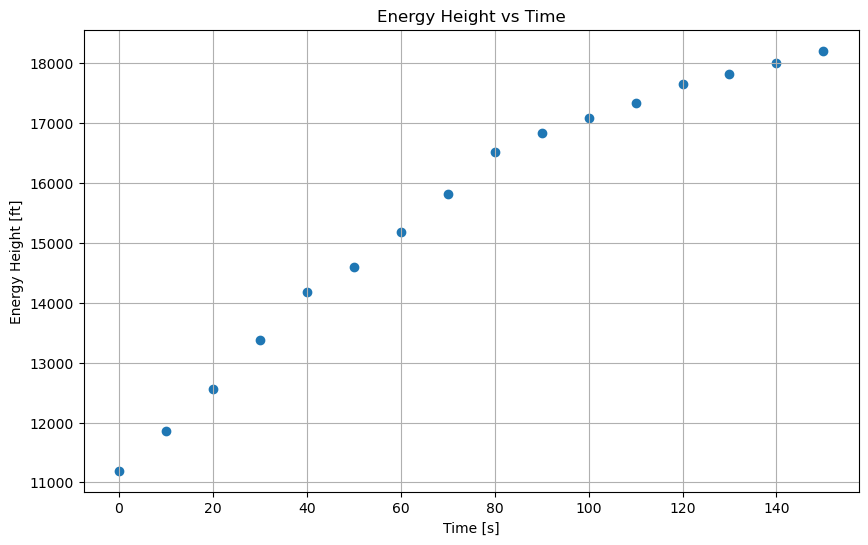

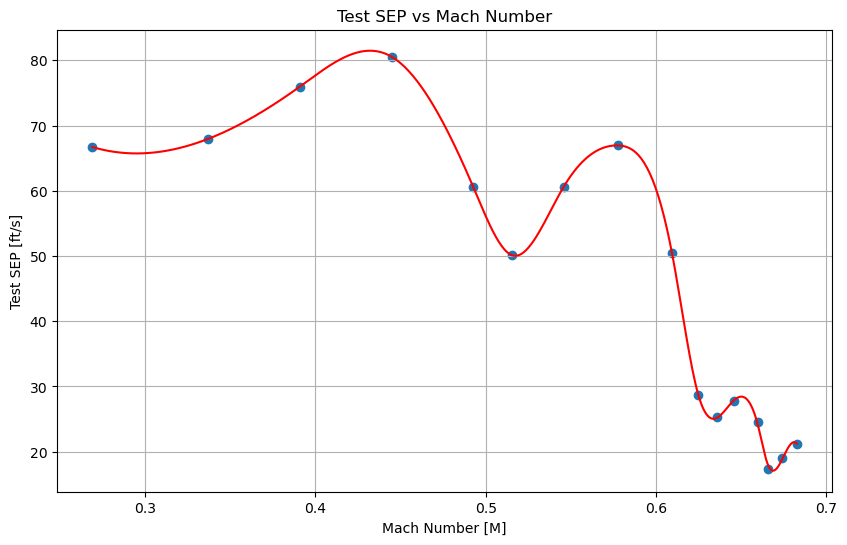

In [41]:
# coefficients = np.polyfit(df_accel["M"], df_accel["p_s_std"], 20)
# polynomial = np.poly1d(coefficients)

# fit_x = np.linspace(df_accel["M"].min(), df_accel["M"].max(), 1000)
# fit_y = polynomial(fit_x)

# Assuming 'mach' and 'sep' are your Mach number and SEP data
mach = np.array(df_accel["M"])  # Replace with actual Mach data
sep = np.array(df_accel["p_s_std"])  # Replace with actual SEP data

# Fit a spline to the data
spline_fit = UnivariateSpline(mach, sep, s=1)  # s=0 forces an exact fit

# Generate smooth data for plotting
mach_smooth = np.linspace(mach.min(), mach.max(), 500)
sep_smooth = spline_fit(mach_smooth)


# Energy Height vs Time
plt.figure(figsize=(10, 6))
plt.scatter(df_accel["time"], df_accel["e_h"])
# plt.plot(fit_x, fit_y)
# plt.plot(df_accel["time"], df_accel["e_h"])
plt.xlabel("Time [s]")
plt.ylabel("Energy Height [ft]")
plt.title("Energy Height vs Time")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_accel["M"], df_accel["p_s_std"])
plt.plot(mach_smooth, sep_smooth, color="red")
plt.xlabel("Mach Number [M]")
plt.ylabel("Test SEP [ft/s]")
plt.title("Test SEP vs Mach Number")
plt.grid()
plt.show()

### Turn Performance

$$
n_{z_\text{sust}} = \sqrt{\frac{P_{s_{1g}} \pi e \text{AR} S 0.7 P_{\text{ssl}} \delta M^2}{V_T W_{\text{std}}}+1}
$$

In [42]:
def n_z_sust(p_s, e, AR, S, P_ssl, delta, M, V_t, W_std):
    return np.sqrt((p_s*np.pi*e*AR*S*0.7*P_ssl*delta*M**2)/(V_t * W_std)+1)

In [43]:
b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
delta = atm.get_std_delta(10000)

df_accel["n_z_sust"] = n_z_sust(df_accel["p_s_std"], e, AR, S, P_ssl, delta, df_accel["M"], df_accel["v_t_standard"], w_s)

### Climb Performance

In [44]:
def climb_angle_to_ROC(climb_angle, v_t_standard):
    return v_t_standard * np.sin(climb_angle) * 60

df_accel["ROC_calc"] = climb_angle_to_ROC(df_accel["climb_angle_std"], df_accel["v_t_standard"])

In [45]:
df_accel

,time,V_i,Hp_i,oat,w_f,ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,v_t_standard,W,p_s_std,ccf,dh/dt_std,ROC,climb_angle_test,climb_angle_std,n_z_sust,ROC_calc
0,0,148,10010,-8,2800,8620,0,0,0,0,...,291.246195,11800,66.715036,-8.001202,-8.338126,-7.424782,-0.025648,-0.028633,2.486126,-500.287575
1,10,186,9940,-8,2800,8620,0,0,0,0,...,365.066363,11800,67.970043,-16.658226,-4.080269,-4.242419,-0.011693,-0.011177,2.759115,-244.816142
2,20,216,9930,-8,2800,8620,0,0,0,0,...,423.275368,11800,75.979982,145.409222,0.522525,0.530107,0.001260,0.001234,3.093540,31.351512
3,30,246,9950,-8,2800,8620,0,0,0,0,...,481.429733,11800,80.562452,NaN,NaN,0.000000,0.000000,NaN,3.367023,NaN
4,40,273,9930,-8,2800,8620,0,0,0,0,...,533.263442,11800,60.657087,-119.165362,-0.509016,-0.530107,-0.001000,-0.000955,3.101530,-30.540966
5,50,286,9940,-8,2800,8620,0,0,0,0,...,558.286453,11800,50.094677,95.229428,0.526042,0.530028,0.000955,0.000942,2.907428,31.562519
6,60,303,9940,-8,2800,8620,0,0,0,0,...,590.821976,11800,60.612367,NaN,NaN,0.000000,0.000000,NaN,3.247077,NaN
7,70,321,9940,-8,2800,8620,0,0,0,0,...,625.163748,11800,66.947624,64.008493,1.045918,1.060292,0.001707,0.001673,3.486217,62.755070
8,80,339,9960,-8,2800,8620,0,0,0,0,...,659.578152,11800,50.480332,-98.037230,-0.514910,-0.530028,-0.000809,-0.000781,3.142368,-30.894589
9,90,348,9930,-8,2800,8620,0,0,0,0,...,676.368761,11800,28.701606,-55.204131,-0.519918,-0.530185,-0.000789,-0.000769,2.484566,-31.195064


### NTPS Way

1. Correct $V_i$ for instrument error, position error and compressibility, then true airspeed in ft/s.
1. Plot $V_t$ vs time.
1. As long as no climb/descent during acceleration. Get the gradient of the plot. 

$$
\left. \frac{dH}{dt} \right|_t = SEP = \frac{V_T}{g} \frac{dV_T}{dt}
$$

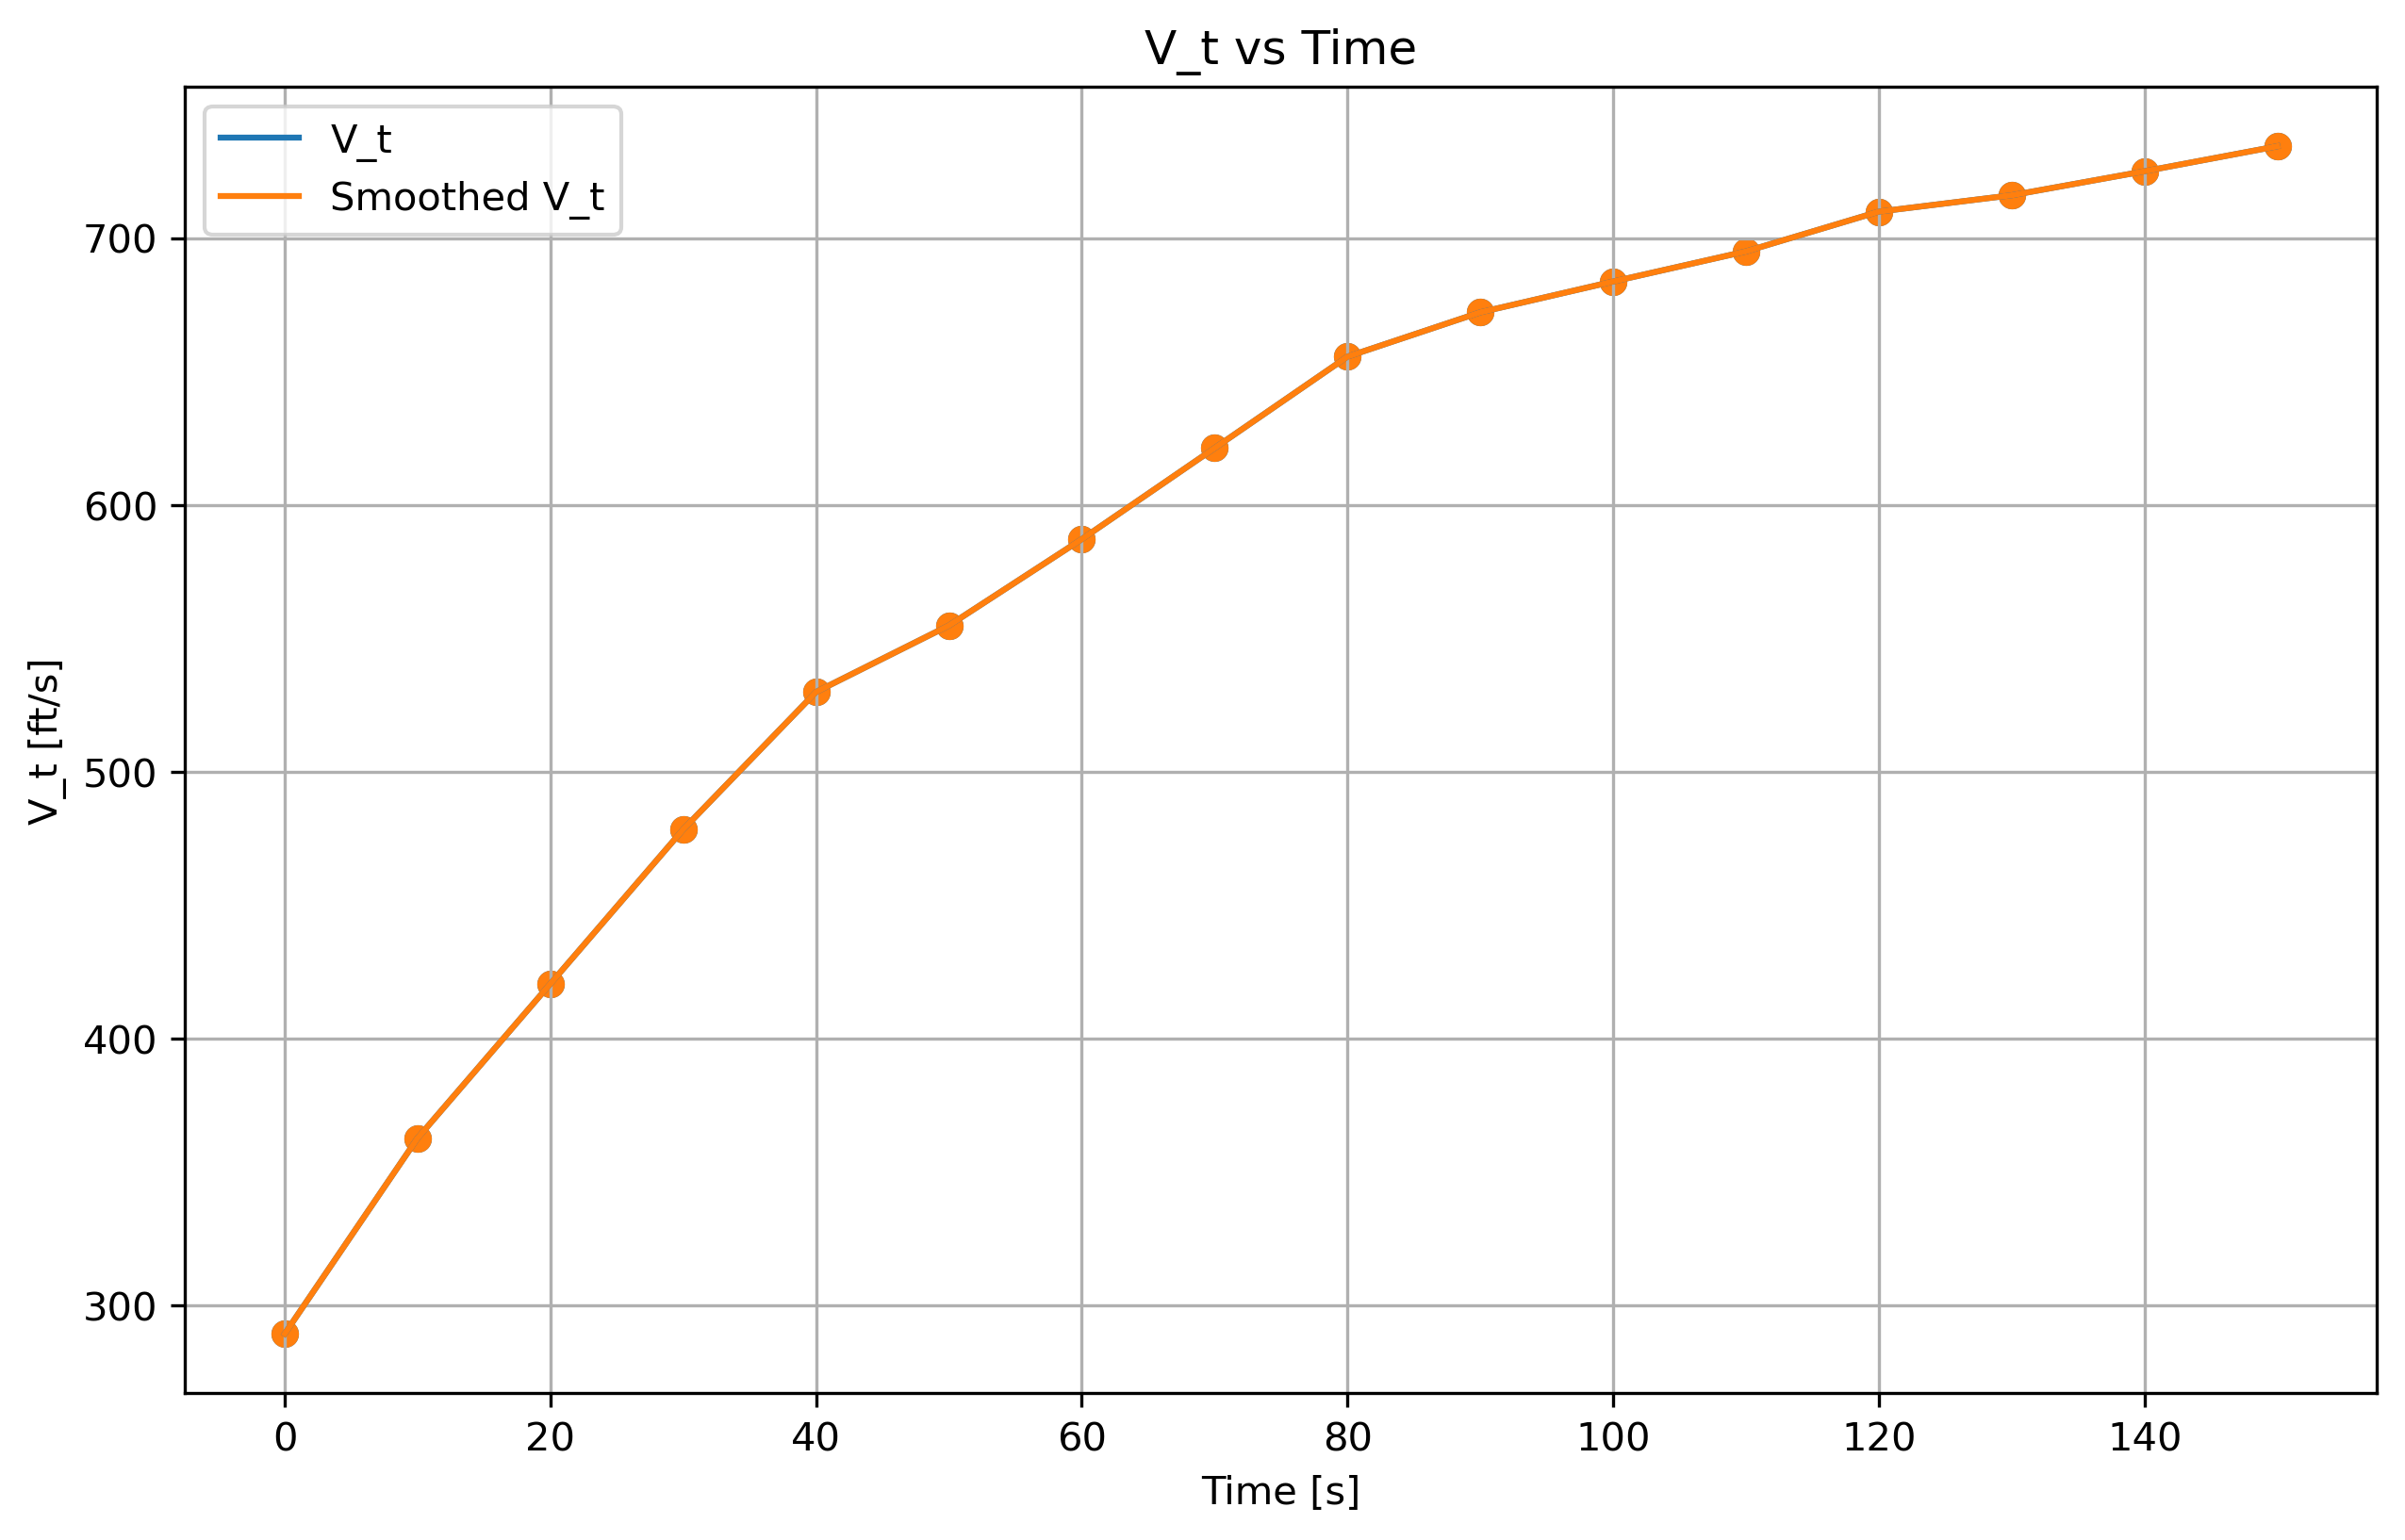

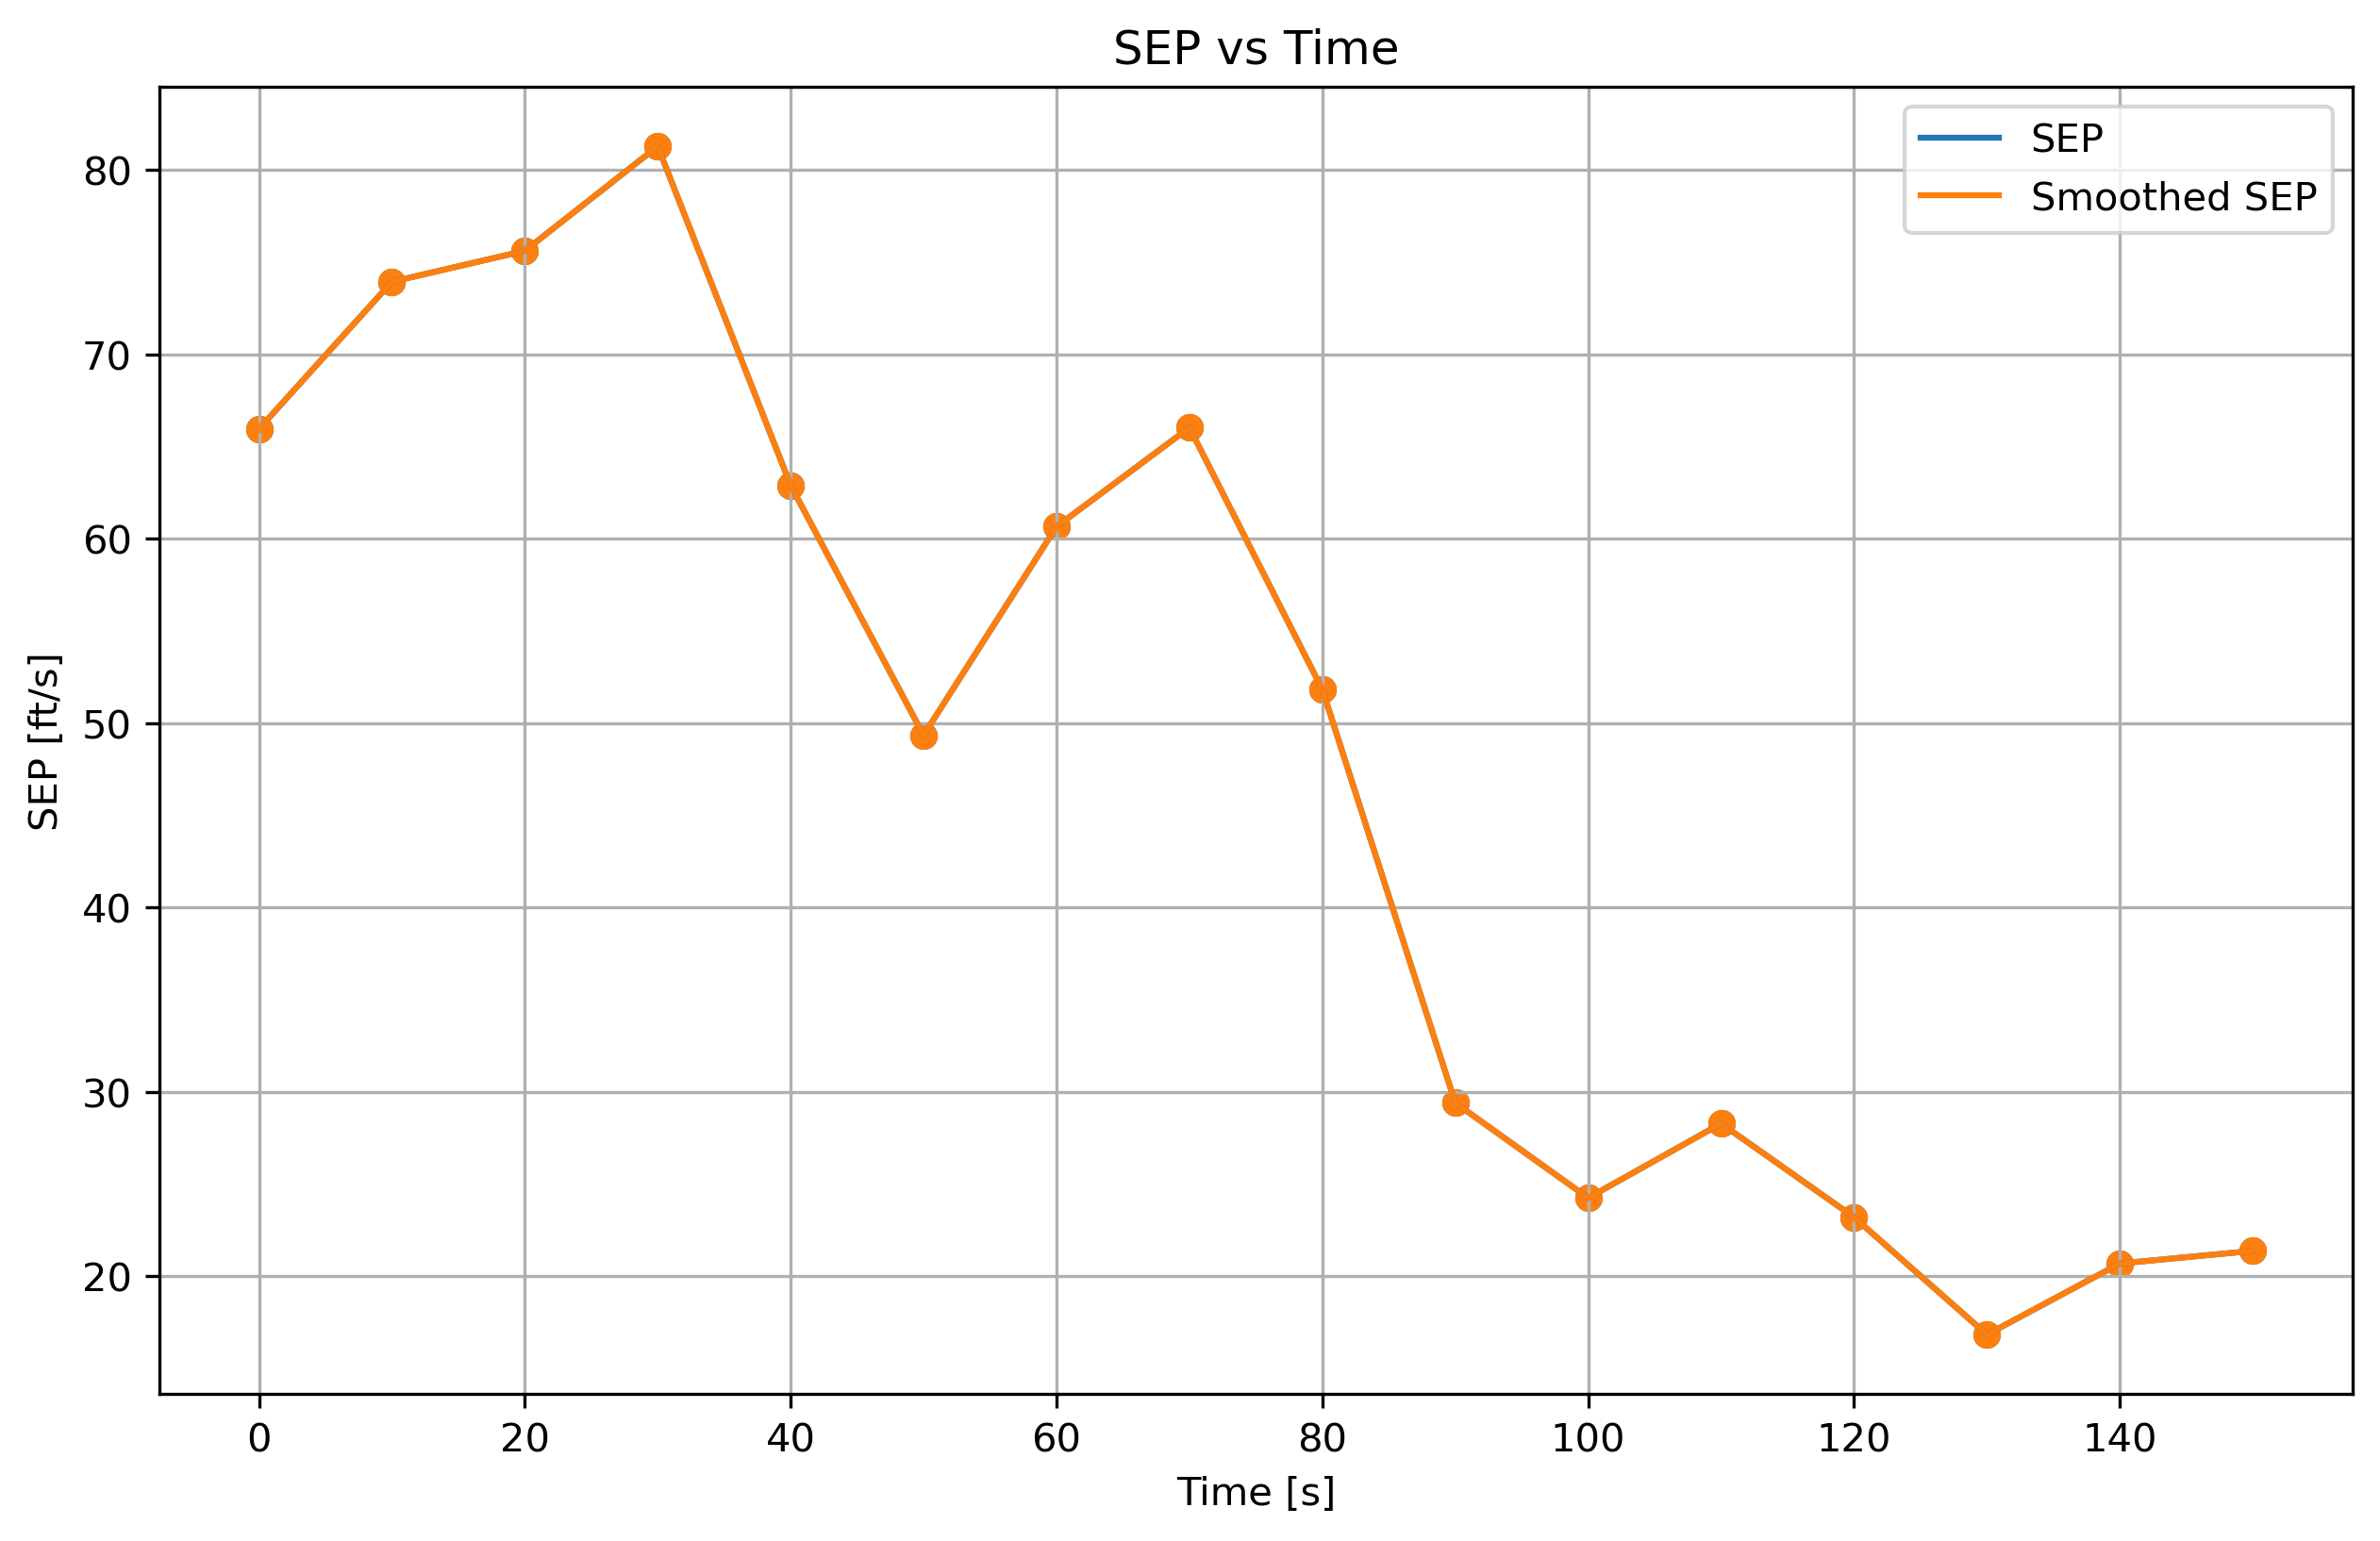

,time,V_i,Hp_i,oat,w_f,ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,ROC,climb_angle_test,climb_angle_std,n_z_sust,ROC_calc,dV_t/dt,SEP_ntps,sg_vt_fps,sg_dV_t/dt,sg_SEP_ntps
0,0,148,10010,-8,2800,8620,0,0,0,0,...,-7.424782,-0.025648,-0.028633,2.486126,-500.287575,7.328931,65.958472,289.521640,7.328931,65.958472
1,10,186,9940,-8,2800,8620,0,0,0,0,...,-4.242419,-0.011693,-0.011177,2.759115,-244.816142,6.556158,73.939884,362.810947,6.556158,73.939884
2,20,216,9930,-8,2800,8620,0,0,0,0,...,0.530107,0.001260,0.001234,3.093540,31.351512,5.783106,75.618078,420.644809,5.783106,75.618078
3,30,246,9950,-8,2800,8620,0,0,0,0,...,0.000000,0.000000,NaN,3.367023,NaN,5.465226,81.285780,478.473068,5.465226,81.285780
4,40,273,9930,-8,2800,8620,0,0,0,0,...,-0.530107,-0.001000,-0.000955,3.101530,-30.540966,3.818212,62.898936,529.949333,3.818212,62.898936
5,50,286,9940,-8,2800,8620,0,0,0,0,...,0.530028,0.000955,0.000942,2.907428,31.562519,2.861124,49.345928,554.837304,2.861124,49.345928
6,60,303,9940,-8,2800,8620,0,0,0,0,...,0.000000,0.000000,NaN,3.247077,NaN,3.323206,60.655671,587.171819,3.323206,60.655671
7,70,321,9940,-8,2800,8620,0,0,0,0,...,1.060292,0.001707,0.001673,3.486217,62.755070,3.418989,66.031165,621.301425,3.418989,66.031165
8,80,339,9960,-8,2800,8620,0,0,0,0,...,-0.530028,-0.000809,-0.000781,3.142368,-30.894589,2.543193,51.824503,655.551594,2.543193,51.824503
9,90,348,9930,-8,2800,8620,0,0,0,0,...,-0.530185,-0.000789,-0.000769,2.484566,-31.195064,1.407391,29.406252,672.165286,1.407391,29.406252


In [46]:
df_accel["dV_t/dt"] = np.gradient(df_accel["v_t_fps"], df_accel["time"])
df_accel["SEP_ntps"] = df_accel["v_t_fps"] / g * df_accel["dV_t/dt"]
df_accel["sg_vt_fps"] = savgol_filter(df_accel["v_t_fps"], len(df_accel) // 5, 2)
df_accel["sg_dV_t/dt"] = np.gradient(df_accel["sg_vt_fps"], df_accel["time"])
df_accel["sg_SEP_ntps"] = df_accel["sg_vt_fps"] / g * df_accel["sg_dV_t/dt"]

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["time"], df_accel["v_t_fps"], label="V_t")
plt.plot(df_accel["time"], df_accel["sg_vt_fps"], label="Smoothed V_t")
plt.scatter(df_accel["time"], df_accel["v_t_fps"])
plt.scatter(df_accel["time"], df_accel["sg_vt_fps"])
plt.xlabel("Time [s]")
plt.ylabel("V_t [ft/s]")
plt.title("V_t vs Time")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["time"], df_accel["SEP_ntps"], label="SEP")
plt.plot(df_accel["time"], df_accel["sg_SEP_ntps"], label="Smoothed SEP")
plt.scatter(df_accel["time"], df_accel["SEP_ntps"])
plt.scatter(df_accel["time"], df_accel["sg_SEP_ntps"])
plt.xlabel("Time [s]")
plt.ylabel("SEP [ft/s]")
plt.title("SEP vs Time")
plt.legend()
plt.grid()
plt.show()
df_accel

Then we need to correct for:

1. Climbing or descending correction
$$
\Delta \left(\frac{dH}{dt}\right)=\left(\frac{H_{\text{final}} - H_{\text{initial}}}{\Delta t}\right)\frac{T_t}{T_s}
$$
2. Non-standard horsepower available correction

_see book_

3. Weight Corrections
$$
\left.\frac{dH}{dt}\right|_s = \frac{W_t}{W_s}\left.\frac{dH}{dt}\right|_t
$$

Supposedly this is a summary of all corrections, however they are not all mentioned in the level acceleration section...

$$
\left. \frac{dH}{dt} \right|_s = \frac{W_t}{W_s} \left[ \frac{T_t}{T_s} \left. \frac{dH}{dt} \right|_t  + \frac{550 \eta BHP_t}{W_t} \left( \sqrt{\frac{T_t}{T_s}} - 1 \right) + \left( \frac{H_{final} - H_{initial}}{\Delta t} \right) \frac{T_t}{T_s} + \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_t} \right)\right]
$$

Corrections here that aren't listed are:

1. Induced drag correction
$$
\Delta \frac{dH}{dt} = \Delta SEP = \frac{\Delta D_i V_T}{W_s} = \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_s} \right)
$$